In [38]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators

# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, save_or_load_onehot, build_data, plot_spherical_harmonics_comparison, plot_cartesian_tensor_comparison)
from utils.utils_model_full_tensor import Network, train, evaluate
import wandb

plt.rcParams["mathtext.fontset"] = "cm"

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

torch device: cuda:0


In [40]:
data_file = '../dataset/symmetrized_permittivity.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)
# Parameters
energy_min = 0  # eV
energy_max = 30  # eV
nstep = 301
new_x = np.linspace(energy_min, energy_max, nstep)


from e3nn.o3 import matrix_z
import torch
import math


# Duplicate the dataset
df_original = df.copy()
df_rotated = df.copy()




rot = o3.rand_matrix().numpy()

def rotate_structure(atoms, rot):
    atoms_rot = atoms.copy()
    atoms_rot.set_positions(atoms_rot.get_positions() @ rot)
    return atoms_rot
df_rotated['symmetrized_structure'] = df_rotated['symmetrized_structure'].map(lambda atoms: rotate_structure(atoms, rot))

# Prepare tensor
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)  # Shape: (201, 3, 3)


# Apply interpolation efficiently
df_rotated['imag_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['imag_symmetrized_permittivity'], row['omega']) for _, row in df_rotated.iterrows()
]
df_original['imag_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['imag_symmetrized_permittivity'], row['omega']) for _, row in df_original.iterrows()
]
# Apply the custom function to create a new column
df_rotated['energies_interp'] = df_rotated.apply(lambda x: new_x, axis=1)
df_original['energies_interp'] = df_original.apply(lambda x: new_x, axis=1)

stack_matrices_tensor = torch.tensor(np.stack(df_rotated['imag_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)  # Shape: (num_samples, 201, 3, 3)
sph_coefs_tensor = x.from_cartesian(stack_matrices_tensor)  # shape: (301, ...depending on irreps)
df_rotated['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list

stack_matrices_tensor = torch.tensor(np.stack(df_original['imag_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)  # Shape: (num_samples, 201, 3, 3)
sph_coefs_tensor = x.from_cartesian(stack_matrices_tensor)  # shape: (301, ...depending on irreps)
df_original['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list


type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

# Find the scaling value
tmp = np.array([df_original.iloc[i]['sph_coefs'] for i in range(len(df_original))])
print(tmp.shape)
scale_data = 9.646872467049155
n_train = 40
print(scale_data)


r_max = 6. # cutoff radius
df_original['data'] = df_original.progress_apply(lambda x: build_data(
    x, 'sph_coefs', scale_data,
    type_onehot, mass_onehot, dipole_onehot, radius_onehot,
    type_encoding, r_max
), axis=1)

df_rotated['data'] = df_rotated.progress_apply(lambda x: build_data(
    x, 'sph_coefs', scale_data,
    type_onehot, mass_onehot, dipole_onehot, radius_onehot,
    type_encoding, r_max
), axis=1)

run_time = '250409'
with open('../model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]


## NN part
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim , **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        data.x = F.relu(self.em_x(data.x))

        # data.x_mass = F.relu(self.em_mass(data.x_mass))
        # data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        # data.x_radius = F.relu(self.em_radius(data.x_radius))
        # crystal_system_embed = F.relu(self.em_crystal_system(data.crystal_system_onehot))  # Shape: (em_dim,)
        # num_nodes = data.x_mass.shape[0]
        # if hasattr(data, 'batch') and data.batch is not None:
        #     crystal_system_embed = crystal_system_embed[data.batch]  # Shape: (num_nodes, em_dim)
        # else:
        #     # Single graph case: repeat for all nodes
        #     crystal_system_embed = crystal_system_embed.squeeze(0).repeat(num_nodes, 1)  # Shape: (num_nodes, em_dim)    
            
        # # tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius, crystal_system_embed], dim=0)  # Shape: (4, num_nodes, em_dim)        
        # tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)  # Shape: (3, num_nodes, em_dim)        

        # tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        # data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        output = super().forward(data)
        # RELU issue, from e3nn discussion, removing because it might break the symmetry
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
            # output = torch_scatter.scatter_add(output, data.batch, dim=0)  # take mean over atoms per example
            # output, _ = torch_scatter.scatter_max(output, data.batch, dim=0)  # max over atoms per examples
        return output

out_dim = len(df_original.iloc[0]['energies_interp'])      # about 200 points
em_dim = 128


use_batch_norm = False
dropout_prob=0

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e +" + str(out_dim) + "x2e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=2,
    max_radius=r_max,
    num_neighbors=n_train,
    reduce_output=True,
    dropout_prob=dropout_prob,
    use_batch_norm = use_batch_norm
)
run_name = f'symmetrized_data_model_im_{run_time}'
# run_name = f'symmetrized_data_model_re_sph_coefs_soa'


wandb.init(
    project="Inference",  # Change this to your project name
    name=run_name,  # Unique identifier for this run
    config={
    }
)





# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '_best.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df_original['data'].values, batch_size=64)
df_original['mse_sph'] = 0.
df_original['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

predictions = [] 
df_original['y_pred_sph'] = None
i0 = 0
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5
        out_dim = model.irreps_out.count(o3.Irrep("0e")) 
        
        output_0e = output[:, :irreps_0e]  # Shape: (batch_size, irreps_0e)
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(output.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        y_0e = d.y[:, :, 0].view(d.y.shape[0], out_dim) 
        y_2e = d.y[:, :, 1:].view(d.y.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        loss_0e = F.mse_loss(output_0e, y_0e)   # MSE or other suitable loss
        loss_2e = F.mse_loss(output_2e, y_2e)   # MSE or other suitable loss
        loss = loss_0e + loss_2e
        
        combined_output = torch.cat([output_0e.unsqueeze(2), output_2e], dim=2)  # Shape: (batch_size, 201, 6)
        predictions.append(combined_output.cpu())

        for batch_idx in range(d.y.shape[0]):
            df_original.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            # df.loc[i0 + batch_idx, 'y_pred_cart'] = [realsphvec2cart(combined_output[batch_idx].cpu().numpy())]
            df_original.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

        # Update batch index counter
        i0 += d.y.shape[0]

column = 'imag_Permittivity_Matrices_interp'

df_original['y_pred_sph'] = df_original['y_pred_sph'].map(lambda x: x[0]) * scale_data

# perm_cartesian_tensor = x.to_cartesian(sph_coefs_tensor)

# Convert all spherical tensors to a batched tensor
sph_tensors = torch.tensor(np.stack(df_original['y_pred_sph'].values))  # Batch process

# Convert using x.to_cartesian in batch
cart_tensors = x.to_cartesian(sph_tensors)

# Assign back to the DataFrame
df_original['y_pred_cart'] = list(cart_tensors.numpy())  # Convert back to list of NumPy arrays


Loading existing data...
(1454, 301, 6)
9.646872467049155


100%|██████████| 23/23 [00:04<00:00,  5.37it/s]


In [41]:
# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '_best.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df_rotated['data'].values, batch_size=64)
df_rotated['mse_sph'] = 0.
df_rotated['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

predictions = [] 
df_rotated['y_pred_sph'] = None
i0 = 0
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5
        out_dim = model.irreps_out.count(o3.Irrep("0e")) 
        
        output_0e = output[:, :irreps_0e]  # Shape: (batch_size, irreps_0e)
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(output.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        y_0e = d.y[:, :, 0].view(d.y.shape[0], out_dim) 
        y_2e = d.y[:, :, 1:].view(d.y.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        loss_0e = F.mse_loss(output_0e, y_0e)   # MSE or other suitable loss
        loss_2e = F.mse_loss(output_2e, y_2e)   # MSE or other suitable loss
        loss = loss_0e + loss_2e
        
        combined_output = torch.cat([output_0e.unsqueeze(2), output_2e], dim=2)  # Shape: (batch_size, 201, 6)
        predictions.append(combined_output.cpu())

        for batch_idx in range(d.y.shape[0]):
            df_rotated.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            # df.loc[i0 + batch_idx, 'y_pred_cart'] = [realsphvec2cart(combined_output[batch_idx].cpu().numpy())]
            df_rotated.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

        # Update batch index counter
        i0 += d.y.shape[0]

column = 'imag_Permittivity_Matrices_interp'

df_rotated['y_pred_sph'] = df_rotated['y_pred_sph'].map(lambda x: x[0]) * scale_data

# perm_cartesian_tensor = x.to_cartesian(sph_coefs_tensor)

# Convert all spherical tensors to a batched tensor
sph_tensors = torch.tensor(np.stack(df_original['y_pred_sph'].values))  # Batch process

# Convert using x.to_cartesian in batch
cart_tensors = x.to_cartesian(sph_tensors)

# Assign back to the DataFrame
df_rotated['y_pred_cart'] = list(cart_tensors.numpy())  # Convert back to list of NumPy arrays

100%|██████████| 23/23 [00:03<00:00,  6.17it/s]


In [42]:
# Compute relative error across all rows
errors = []

for orig_tensor, rot_tensor in zip(df_original['y_pred_cart'], df_rotated['y_pred_cart']):
    orig_tensor = np.array(orig_tensor)  # shape: (n_energy, 3, 3)
    rot_tensor = np.array(rot_tensor)

    # Apply R A R^T to all energy slices: vectorized
    rotated_back = rot @ orig_tensor @ rot.T  # shape: (n_energy, 3, 3)

    # Compute relative Frobenius norm difference
    diff = np.linalg.norm(rot_tensor - rotated_back) / (np.linalg.norm(rot_tensor) + 1e-10)
    errors.append(diff)

# Report mean and max error
print(f"Mean relative error: {np.mean(errors):.6e}")
print(f"Max relative error: {np.max(errors):.6e}")


Mean relative error: 2.632279e-03
Max relative error: 3.389156e-02


(array([1.041e+03, 2.790e+02, 8.200e+01, 3.400e+01, 9.000e+00, 4.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([1.48492591e-16, 3.38915608e-03, 6.77831216e-03, 1.01674682e-02,
        1.35566243e-02, 1.69457804e-02, 2.03349365e-02, 2.37240926e-02,
        2.71132486e-02, 3.05024047e-02, 3.38915608e-02]),
 <BarContainer object of 10 artists>)

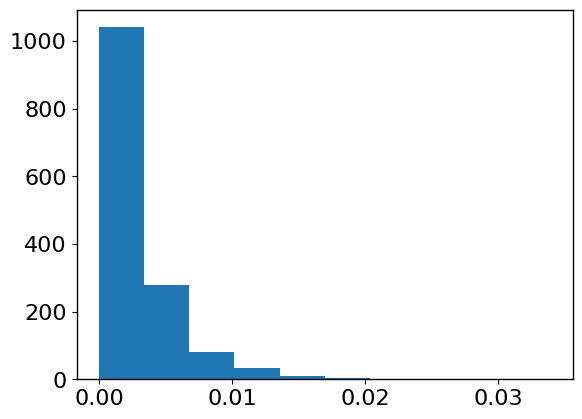

In [43]:
plt.hist(errors)
